## Numerical experiments math and Data Science Project
#### Authors: Beltrame and Marchionne

In the following, we are presenting the results of the numerical experiments associated to the following papers:

- Training ReLU networks to high uniform accuracy is intractable; Julius Berner; Philipp Grohs and Felix Voigtlaender


The numerical experiments aim to prove that we can find relevant and domain-specific problems of usign neural networks in solving even simple tasks.


## Target function: x $\rightarrow$ log(sin(50x) + 2) + sin(5x)

In the next line we are implementing a Student Teacher Neural Network regressor.

The Student-Teacher Framework is a machine learning approach where a "student" model is trained to mimic the outputs of a pre-trained "teacher" model. The student model is typically smaller and faster, while the teacher model is larger and slower, but more accurate. During training, the student model is fed input data and its predictions are compared to the ground-truth labels produced by the teacher model. The student model's parameters are then updated based on this comparison, until the student's predictions match the teacher's predictions with high accuracy. The end result is a compact, efficient model that has learned from the knowledge of a larger, more accurate model.

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

    
# custom
from Functions import plot_result, MLPRegressor, create_dataset, StudentTeacher, ModelEvaluator, StudentNet, TeacherNet

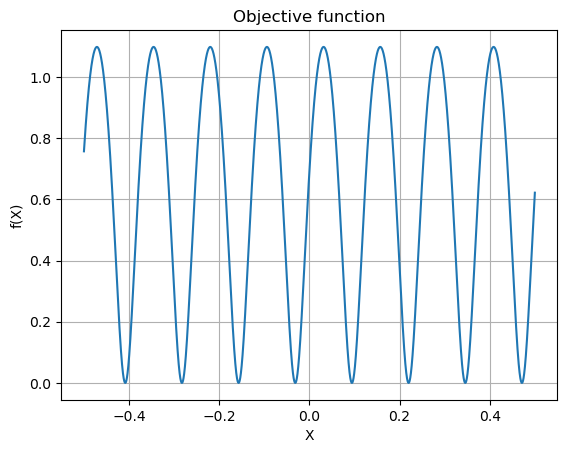

In [12]:
# define x
epsilon = 0.0001
x = np.arange(-0.5, 0.5, epsilon)
x_init = x
function = lambda x : np.log(np.sin(50 * x) + 2) + np.sin(5*x)
fx = [function(e) for e in x]
plot_result(x_init, fx, "X", "f(X)", "Objective function")

x_train, x_test, y_train, y_test = create_dataset(x, fx)



[]

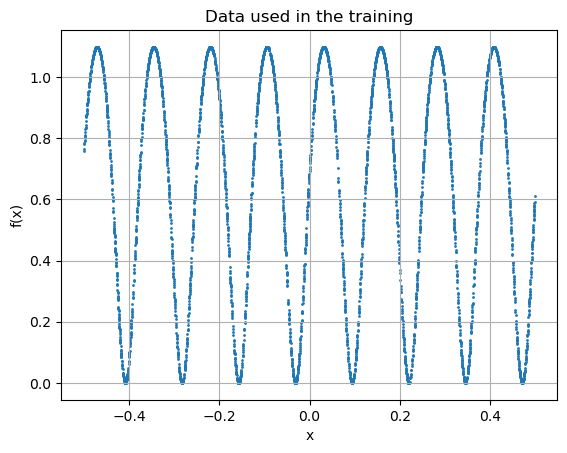

In [13]:
plt.scatter(x_train, y_train, 1)
plt.title("Data used in the training")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.plot()

## Simple regressor

In [31]:
class Regressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(model, x_train, y_train, loss_fn, optimizer, device, epochs):
        total_loss = 0
        x_train = torch.tensor(x_train).to(device)
        y_train = torch.tensor(y_train).to(device)
        for _ in range(epochs):
            optimizer.zero_grad()
            outputs = model(x_train)
            loss = loss_fn(outputs, y_train)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(y_train)

In [32]:
regressor = Regressor(1, 100, 1).to("cuda")
criterion = nn.MSELoss()
# Initialize optimizer
optimizer = optim.SGD(student.parameters(), lr=0.0001)
regressor.train(x_train, y_train, criterion, optimizer, "cuda", 1000)

C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1374913690.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).to(device)
C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1374913690.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)


0.13550467789173126

C:\Users\beltr\AppData\Local\Temp\ipykernel_752\2337539846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x).float().to("cuda")


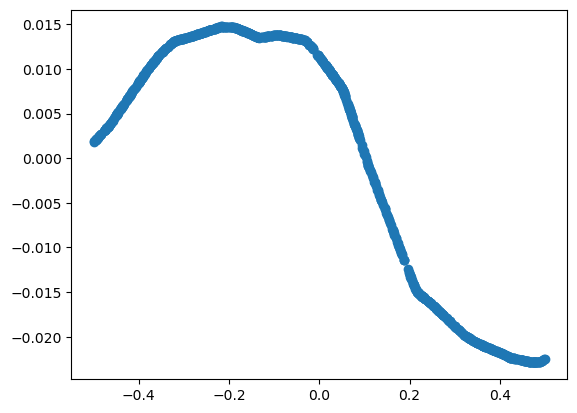

In [33]:
def predict_with_regressor(MLP, x):
    with torch.no_grad():
        inputs = torch.tensor(x).float().to("cuda")
        outputs = MLP(inputs)
        return outputs.cpu().detach().numpy()
    
y_preds = predict_with_regressor(regressor, x_test)

plt.scatter(x_test, y_preds, label="Predictions on test data")

## The teacher

In [14]:
# Define the teacher model (larger, more accurate model)
class teacher(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(teacher, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, num_classes)
        self.dropout_prob = dropout_prob

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.relu(self.batch_norm3(self.fc3(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.relu(self.batch_norm4(self.fc4(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = self.fc5(x)
        return x

## The student

In [15]:
# Define the student model (smaller, faster model)
class student(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(student, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, num_classes)
        self.dropout_prob = dropout_prob

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.relu(self.batch_norm3(self.fc3(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.relu(self.batch_norm4(self.fc4(x)))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = self.fc5(x)
        return x

Pass the informations from the larger network (teacher) to the smaller (student)

In [16]:
# Train the student model using the knowledge from the teacher model
def train_student(student, teacher, x_train, y_train, criterion, optimizer, num_epochs):
    x_train = torch.tensor(x_train).to("cuda")
    y_train = torch.tensor(y_train).to("cuda")
    
    for epoch in range(num_epochs):
        inputs = torch.tensor(x_train).to("cuda")
        labels = torch.tensor(y_train).to("cuda")
        optimizer.zero_grad()

        # Obtain predictions from the teacher model
        with torch.no_grad():
            teacher_outputs = teacher(inputs)

        # Use teacher predictions as target for the student model
        student_outputs = student(inputs)
        loss = criterion(student_outputs, teacher_outputs)
        loss.backward()
        optimizer.step()

In [17]:
# Initialize models and loss function
teacher = teacher(1, 20, 1, 0.3).to("cuda")
student = student(1, 100, 1, 0.3).to("cuda")
criterion = nn.MSELoss().to("cuda")

# Initialize optimizer
optimizer = optim.SGD(student.parameters(), lr=0.0001)

In [18]:
# Train the student model
num_epochs = 10000
train_student(student, teacher, x_train, y_train, criterion, optimizer, num_epochs)

C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1043102121.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).to("cuda")
C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1043102121.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to("cuda")
C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1043102121.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x_train).to("cuda")
C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1043102121.py:8: UserWarning: To co

Get the predictions

C:\Users\beltr\AppData\Local\Temp\ipykernel_752\1287792549.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x).float().to("cuda")


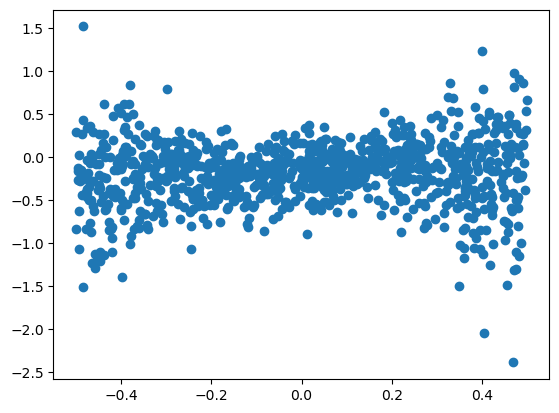

In [19]:
def predict_with_student(student, x):
    with torch.no_grad():
        inputs = torch.tensor(x).float().to("cuda")
        outputs = student(inputs)
        return outputs.cpu().detach().numpy()

y_preds = predict_with_student(teacher, x_test)

plt.scatter(x_test, y_preds, label="Predictions on test data")

We are using a support class that takes a *student teacher* neural network.

In [20]:
# width of the student MLP
hidden_size_s = [10, 20, 30]

#define students and teachers networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a student-teacher object
st = StudentTeacher(device='cuda')

# Train the student network
st.fit(x_train, y_train)

C:\Users\beltr\Documents\GitHub\Math_proj\Functions.py:541: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to("cuda")
C:\Users\beltr\Documents\GitHub\Math_proj\Functions.py:542: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).to("cuda")


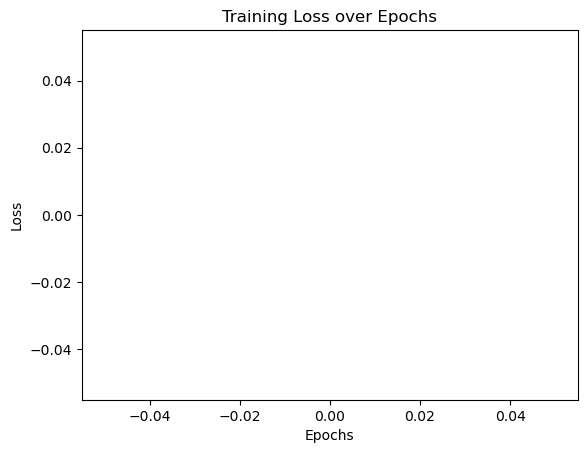

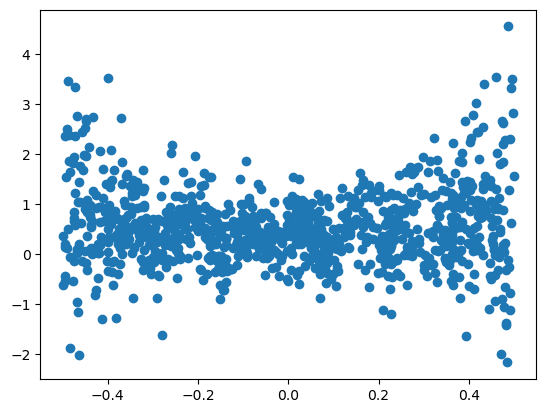

In [21]:
st.plot_loss()
plt.scatter(x_test, st.predict(x_test).cpu().detach().numpy())

In [22]:
# number of trials per layer width
T = 10
evaluator = ModelEvaluator(x_train, x_test, y_train, y_test, hidden_size_s, T)

In [23]:
evaluator.train_models()

KeyboardInterrupt: 

In [ ]:
evaluator.plot_models(R = 20)
plt.plot(x_init, fx, label="Target function")
plt.show()